In [2]:
import argparse, json, pickle
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [57]:
# Training settings
batch_size = 1024
test_batch_size = 3000

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args('--batch-size {} --test-batch-size {}'.format(batch_size, test_batch_size).split()) # default: taken from sys.argv
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

MNIST_data_path = '../HW1-1/git_ignored/MNIST/MNIST_data'

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_data_path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # (mean, std)
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_data_path, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

train_eval_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_data_path, train=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [58]:
tensorboard_category = 'batch_{}'.format(batch_size)

class CNN_2FC(nn.Module):
    def __init__(self):
        super(CNN_2FC, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # p=0.5 by default
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.max_pool1(self.conv1(x))) # (input, kernel_size)
        x = F.relu(self.max_pool2(self.conv2_drop(self.conv2(x)),))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN_2FC()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print('model params:', num_params)
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train() # set to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, requires_grad=True), Variable(target) # storing gradients for input data
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        # get gradients of loss wrt. input here
        # data.grad #64x1x28x28
        # IMPORTANT: after calculating gradient of input data, we do not update on it
        data.requires_grad = False
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def trained_epoch(epoch):
    model.eval()# set to evaluation mode
    trained_loss = 0
    correct = 0
    for data, target in train_eval_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        trained_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    trained_loss /= len(train_eval_loader.dataset)
    trained_accuracy = correct / len(train_eval_loader.dataset)
    writer.add_scalar('{}/train_loss'.format(tensorboard_category), trained_loss, epoch) # try add_scalars() later
    writer.add_scalar('{}/train_accuracy'.format(tensorboard_category), trained_accuracy, epoch)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        trained_loss, correct, len(train_loader.dataset),
        100. * trained_accuracy))
            
def test(epoch):
    model.eval()# set to evaluation mode
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    writer.add_scalar('{}/test_loss'.format(tensorboard_category), test_loss, epoch) # try add_scalars() later
    writer.add_scalar('{}/test_accuracy'.format(tensorboard_category), test_accuracy, epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    
    writer.export_scalars_to_json("./batch_{}.json".format(batch_size))
    
def model_eval_and_save(save_path=None):
    model.eval()# eval only affects stuff like dropout and batch norm, doesn't remove the ability to backprop
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    sensitivity_test = 0
    sensitivity_train = 0
    
    for idx, (data, target) in enumerate(test_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, requires_grad=True), Variable(target) # no intermediate states will be saved
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # not caring about loss value here, just need it to compute gradients
        loss.backward()
        grads_on_input = np.array(data.grad.data).reshape(-1,28,28) # (1000, 28, 28)
        batch_of_sensitivities = np.sqrt(np.sum(grads_on_input**2, axis=(1,2))) # (1000,)
        sensitivity_test += np.sum(batch_of_sensitivities)
    sensitivity_test /= len(datasets.MNIST(MNIST_data_path, train=False))

    for idx, (data, target) in enumerate(train_eval_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, requires_grad=True), Variable(target) # no intermediate states will be saved
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # not caring about loss value here, just need it to compute gradients
        loss.backward()
        grads_on_input = np.array(data.grad.data).reshape(-1,28,28) # (1000, 28, 28)
        batch_of_sensitivities = np.sqrt(np.sum(grads_on_input**2, axis=(1,2))) # (1000,)
        sensitivity_train += np.sum(batch_of_sensitivities)
    sensitivity_train /= len(datasets.MNIST(MNIST_data_path, train=True))
    
    if save_path:
        torch.save(model.state_dict(), save_path)
    
    return sensitivity_train, sensitivity_test

model params: 21840


#### train model (can use for loop to train multiple models)

In [138]:
writer = SummaryWriter()
for epoch in range(1, args.epochs + 1):
    train(epoch)
    trained_epoch(epoch)
    test(epoch)
writer.close()

save_path = './model_batch_{}.pth'.format(batch_size)
sensitivity_train, sensitivity_test = model_eval_and_save(save_path)
json.dump({'train': sensitivity_train, 'test': sensitivity_test},
          open("sensitivity_batch_{}.json".format(batch_size), 'w'))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360069
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.305241
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.285596
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.269358
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.261107
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.240292

Train set: Average loss: 2.1836, Accuracy: 21552/60000 (36%)

Test set: Average loss: 2.1807, Accuracy: 3676/10000 (37%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.203102
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.169038
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.093908
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.019388
Train Epoch: 2 [40960/60000 (68%)]	Loss: 1.964313
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.837047

Train set: Average loss: 1.5838, Accuracy: 36854/60000 (61%)

Test set: Average loss: 1.5672, Accuracy: 6274/10000 (63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.754678
Train Epoch: 3 [10240/60000 (17%)]	Loss: 1.720100
Train Epoch: 3 [20480/60000 (34%)]	Loss: 1.596864
Train Epoch: 3 [307

#### get alpha interpolation data

In [47]:
def eval_interpol():
    model_interpol.eval()# set to evaluation mode
    train_loss = 0
    train_correct = 0
    for data, target in train_eval_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model_interpol(data)
        train_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    train_loss /= len(train_eval_loader.dataset)
    train_acc = train_correct / len(train_eval_loader.dataset)
    
    test_loss = 0
    test_correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model_interpol(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        test_correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    
    return (train_loss, train_acc, test_loss, test_acc)

In [6]:
params_64 = torch.load('model_batch_64.pth')
params_1024 = torch.load('model_batch_1024.pth')

In [48]:
for i in np.arange(-1, 2.0001, 0.1):
    alpha = round(i,2)
    print('alpha:', alpha)
    params_interpol = {}
    for param_name in params_64:
        params_interpol[param_name] = params_64[param_name]*(1 - alpha) + params_1024[param_name]*alpha

    model_interpol = CNN_2FC()
    model_interpol.load_state_dict(params_interpol)
    if args.cuda:
        model_interpol.cuda()

    train_loss, train_acc, test_loss, test_acc = eval_interpol()
    print('train_loss', train_loss, 'train_acc', train_acc, 'test_loss', test_loss, 'test_acc', test_acc)
    json.dump({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc},
              open("loss_acc_alpha_{}.json".format(alpha), 'w'))

alpha: -1.0
train_loss 1.5163946044921874 train_acc 0.8024666666666667 test_loss 1.5535622192382812 test_acc 0.804
alpha: -0.9
train_loss 0.97461162109375 train_acc 0.8448666666666667 test_loss 1.0117991577148437 test_acc 0.8465
alpha: -0.8
train_loss 0.589552978515625 train_acc 0.88665 test_loss 0.6229694274902344 test_acc 0.8852
alpha: -0.7
train_loss 0.3337844472249349 train_acc 0.9235333333333333 test_loss 0.3609141265869141 test_acc 0.9214
alpha: -0.6
train_loss 0.1814043955485026 train_acc 0.9515333333333333 test_loss 0.20691807556152345 test_acc 0.9501
alpha: -0.5
train_loss 0.0992752202351888 train_acc 0.9706666666666667 test_loss 0.12093736152648926 test_acc 0.9686
alpha: -0.4
train_loss 0.05525187225341797 train_acc 0.9824 test_loss 0.07330666198730469 test_acc 0.9786
alpha: -0.3
train_loss 0.03118588778177897 train_acc 0.9896 test_loss 0.04785512542724609 test_acc 0.9868
alpha: -0.2
train_loss 0.018584943834940592 train_acc 0.9939833333333333 test_loss 0.034822952270507815 t

In [ ]:
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))

#### get sensitivities (because I screwed up the first time)

In [61]:
for current_batch_size in [16, 64, 128, 256, 1024, 2048, 4096, 8192]:
    print('current_batch_size:', current_batch_size)
    model = CNN_2FC()
    model.load_state_dict(torch.load('model_batch_{}.pth'.format(current_batch_size)))
    if args.cuda:
        model.cuda()
    sensitivity_train, sensitivity_test = model_eval_and_save()
    json.dump({'train': sensitivity_train, 'test': sensitivity_test},
          open("sensitivity_batch_{}.json".format(current_batch_size), 'w'))

current_batch_size: 16
current_batch_size: 64
current_batch_size: 128
current_batch_size: 256
current_batch_size: 1024
current_batch_size: 2048
current_batch_size: 4096
current_batch_size: 8192


#### use tensorboardX to draw model structure

In [ ]:
# need to comment out model's cuda() before writing graph
with SummaryWriter(comment='MNIST_2FC') as w:
    dummy_input = Variable(torch.rand(1000, 1, 28, 28))
    w.add_graph(model, (dummy_input, ))

## Plot graphs

#### Parse data (sensitivity)

In [65]:
sensitivities_test = []
sensitivities_train = []
for batchsize in [16, 64, 128, 256, 1024, 2048, 4096, 8192]:
    data = json.load(open('sensitivity_batch_{}.json'.format(batchsize)))
    sensitivities_test.append(data['test'])
    sensitivities_train.append(data['train'])

In [69]:
loss_test = []
loss_train = []
acc_test = []
acc_train = []
for batchsize in [16, 64, 128, 256, 1024, 2048, 4096, 8192]:
    data = json.load(open('batch_{}.json'.format(batchsize)))
    loss_test.append(data['batch_{}/test_loss'.format(batchsize)][-1][2])
    loss_train.append(data['batch_{}/train_loss'.format(batchsize)][-1][2])
    acc_test.append(data['batch_{}/test_accuracy'.format(batchsize)][-1][2])
    acc_train.append(data['batch_{}/train_accuracy'.format(batchsize)][-1][2])

#### Parse data (alpha)

In [72]:
x = []
loss_test = []
loss_train = []
acc_test = []
acc_train = []
for i in np.arange(-1, 2.0001, 0.1):
    alpha = round(i,2)
    x.append(alpha)
    data = json.load(open('loss_acc_alpha_{}.json'.format(alpha)))
    
    loss_test.append(data['test_loss'])
    loss_train.append(data['train_loss'])
    acc_test.append(data['test_acc'])
    acc_train.append(data['train_acc'])

In [50]:
delta_loss = []
delta_acc = []
for i in range(len(loss_test)):
    delta_loss.append(loss_test[i] - loss_train[i])
    delta_acc.append(acc_test[i] - acc_train[i])

In [54]:
delta_loss

[0.03716761474609376,
 0.03718753662109375,
 0.03341644897460938,
 0.027129679361979187,
 0.025513680013020845,
 0.021662141291300466,
 0.018054789733886724,
 0.01666923764546712,
 0.016238008435567223,
 0.016096909777323407,
 0.0159792631149292,
 0.014606165504455567,
 0.011728256861368816,
 0.009037415631612138,
 0.007140095901489257,
 0.005109969584147132,
 0.003083075841267907,
 0.0010741224924723305,
 -0.0004094618479410783,
 -0.0009314100901285788,
 -0.0001669099171956387,
 0.0003274630228678396,
 0.0007547075907389303,
 8.042653401693634e-06,
 -0.005340601603190082,
 -0.036905912272135466,
 -0.060798990885416515,
 -0.0075037597656244515,
 0.12416103515625032,
 0.366307291666665,
 0.7122153645833293]

#### Vanilla plot

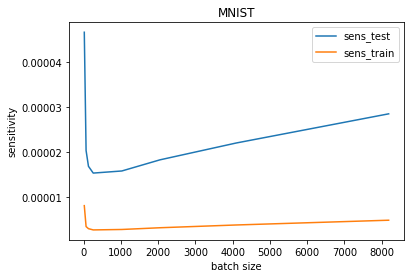

In [6]:
x = [16, 64, 128, 256, 1024, 2048, 4096, 8192]
sens_test, = plt.plot(x, sensitivities_test, label='sens_test')
sens_train, = plt.plot(x, sensitivities_train, label='sens_train')
plt.legend(handles=[sens_test, sens_train])
plt.xlabel('batch size')
plt.ylabel('sensitivity')
plt.title('MNIST')
plt.savefig('sensitivities.png')
plt.show()

#### Draw alpha - loss_acc

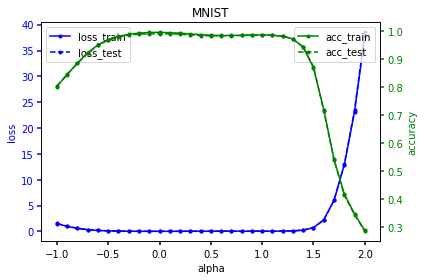

In [73]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
####### par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

####### par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

####### make_patch_spines_invisible(par2)
# Second, show the right spine.

####### par2.spines["right"].set_visible(True)

p1, = host.plot(x, loss_train, "b-", marker='.', label="loss_train")
p2, = host.plot(x, loss_test, 'b--', marker='.', label="loss_test")
p3, = par1.plot(x, acc_train, "g-", marker='.', label="acc_train")
p4, = par1.plot(x, acc_test, "g--", marker='.', label="acc_test")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)

####### par2.set_ylim(1, 65)

host.set_xlabel("alpha")
host.set_ylabel("loss")
par1.set_ylabel("accuracy")

####### par2.set_ylabel("unknown")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
####### par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)

####### par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3, p4]

# host.legend(lines, [l.get_label() for l in lines])
first_legend = host.legend(handles=[p1, p2], loc=2)
ax = host.add_artist(first_legend)
host.legend(handles=[p3, p4], loc=1)

plt.title('MNIST')
plt.tight_layout()
plt.savefig('alpha_loss_acc.png', dpi=199)
plt.show()

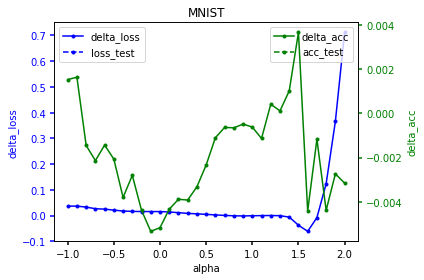

In [74]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
####### par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

####### par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

####### make_patch_spines_invisible(par2)
# Second, show the right spine.

####### par2.spines["right"].set_visible(True)

p1, = host.plot(x, delta_loss, "b-", marker='.', label="delta_loss")
p3, = par1.plot(x, delta_acc, "g-", marker='.', label="delta_acc")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)

####### par2.set_ylim(1, 65)

host.set_xlabel("alpha")
host.set_ylabel("delta_loss")
par1.set_ylabel("delta_acc")

####### par2.set_ylabel("unknown")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
####### par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)

####### par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p3]

# host.legend(lines, [l.get_label() for l in lines])
first_legend = host.legend(handles=[p1, p2], loc=2)
ax = host.add_artist(first_legend)
host.legend(handles=[p3, p4], loc=1)

plt.title('MNIST')
plt.tight_layout()
plt.savefig('deltas.png', dpi=199)
plt.show()

#### Draw sensitivity - loss

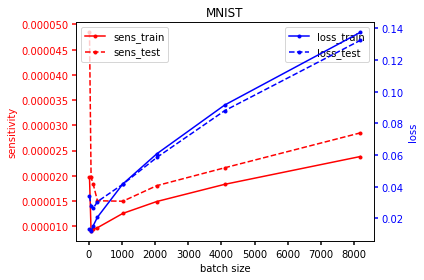

In [70]:
x = [16, 64, 128, 256, 1024, 2048, 4096, 8192]

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
####### par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

####### par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

####### make_patch_spines_invisible(par2)
# Second, show the right spine.

####### par2.spines["right"].set_visible(True)

p1, = host.plot(x, sensitivities_train, "r-", marker='.', label="sens_train")
p2, = host.plot(x, sensitivities_test, "r--", marker='.', label="sens_test")
p3, = par1.plot(x, loss_train, "b-", marker='.', label="loss_train")
p4, = par1.plot(x, loss_test, "b--", marker='.', label="loss_test")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)

####### par2.set_ylim(1, 65)

host.set_xlabel("batch size")
host.set_ylabel("sensitivity")
par1.set_ylabel("loss")

####### par2.set_ylabel("unknown")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
####### par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)

####### par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3, p4]

# host.legend(lines, [l.get_label() for l in lines])
first_legend = host.legend(handles=[p1, p2], loc=2)
ax = host.add_artist(first_legend)
host.legend(handles=[p3, p4], loc=1)

plt.title('MNIST')
plt.tight_layout()
plt.savefig('sensitivities_loss.png', dpi=199)
plt.show()

#### Draw sensitivity - acc

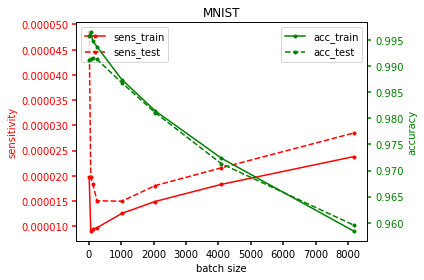

In [71]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
####### par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

####### par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

####### make_patch_spines_invisible(par2)
# Second, show the right spine.

####### par2.spines["right"].set_visible(True)

p1, = host.plot(x, sensitivities_train, "r-", marker='.', label="sens_train")
p2, = host.plot(x, sensitivities_test, "r--", marker='.', label="sens_test")
p3, = par1.plot(x, acc_train, "g-", marker='.', label="acc_train")
p4, = par1.plot(x, acc_test, "g--", marker='.', label="acc_test")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)

####### par2.set_ylim(1, 65)

host.set_xlabel("batch size")
host.set_ylabel("sensitivity")
par1.set_ylabel("accuracy")

####### par2.set_ylabel("unknown")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
####### par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)

####### par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3, p4]

# host.legend(lines, [l.get_label() for l in lines])
first_legend = host.legend(handles=[p1, p2], loc=2)
ax = host.add_artist(first_legend)
host.legend(handles=[p3, p4], loc=1)

plt.title('MNIST')
plt.tight_layout()
plt.savefig('sensitivities_acc.png', dpi=199)
plt.show()